# Описание проекта <a class="anchor" id="1"></a>

**Наше задание:** провести анализ данных и сегментировать покупателей на основе истории их покупок.

У нас в распоряжении есть сведения о транзакциях интернет-магазина для дома и быта "Пока все ещё тут" в csv-файле.
Колонки в  *ecommerce_dataset.csv* :
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

Нам предстоит:
 * разбить данные на категории товаров и выявить самые популярные товары для клиентов;

 * определить частоту и сумму заказов для клиентов интернет-магазина;

 * сегментировать покупателей интернет-магазина;

 * сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      * выделить целевые группы клиентов;
      * предложить меры по удержанию клиентов;
      * определить другие особенности взаимодействия с клиентами

<a class="anchor" id="2"></a>
## Разделы исследования данных

* [Загружаем данные и подготавливаем их к анализу](#chapter1)

* [Проводим исследовательский анализ данных](#chapter2)

    * [Количество заказов и средний чек на пользователя](#section_2_1)
    * [Когортный анализ и LTV](#section_2_2)

* [Сегментация пользователей](#chapter3)
    
* [Проверка гипотез](#chapter4)

* [Выводы и рекомендации](#chapter5)

* [Дополнительные материалы](#chapter6)

<a class="anchor" id="chapter1"></a> 
## Загружаем данные и подготавливаем их к анализу 
<a class="anchor" href="#2">Вернуться к оглавлению</a>

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('max_colwidth', 800)

In [3]:
# Подгружаем датасет и сохраняем в переменную df
try:
    df = pd.read_csv('/datasets/ecommerce_dataset.csv')
except:
    df = pd.read_csv('ecommerce_dataset.csv')

In [4]:
# Выведем на экран первые 5 строк таблицы
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
#Изучим информацию о самой таблице с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [6]:
#Изменим колонку с датой на удобный формат
df['date'] = pd.to_datetime(df['date'], format ='%Y%m%d%H')

In [7]:
#Понижаем разрядность целочисленных значений
df['order_id'] = pd.to_numeric(df['order_id'], downcast='signed')
df['quantity'] = pd.to_numeric(df['quantity'], downcast='signed')

In [8]:
#Изучим информацию о самой таблице с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int32
product        6737 non-null object
quantity       6737 non-null int16
price          6737 non-null float64
dtypes: datetime64[ns](1), float64(1), int16(1), int32(1), object(2)
memory usage: 250.1+ KB


In [9]:
# Выведем на экран первые 5 строк таблицы
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [10]:
#Приведем данные к нижнему регистру в колонке с товарами
df['product'] = df['product'].str.lower()

In [11]:
#Просмотрим количество пропусков в процентном выражении таблицы
df.isna().mean()

date           0.0
customer_id    0.0
order_id       0.0
product        0.0
quantity       0.0
price          0.0
dtype: float64

In [12]:
#Определим количество дубликатов в таблице
df.duplicated().value_counts()

False    6737
dtype: int64

In [13]:
#Выведем на экран первое и последнее время в датасете
display(
df['date'].min(),
df['date'].max())

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 16:00:00')

In [14]:
#Выведем на экран число неположительных или нулевых значений колонки
(df['price'] <= 0).value_counts()

False    6737
Name: price, dtype: int64

In [15]:
#Выведем на экран число неположительных или нулевых значений колонки
(df['quantity'] <= 0).value_counts()

False    6737
Name: quantity, dtype: int64

Мы загрузили и просмотрели общую информацию о датасете. Изменили тип данных для колонки с датой и понизили разрядность некоторых колонок для экономии места на диске. Привели названия товаров к нижнему регистру для удобства дальнейшего анализа.

Данные за период с *01 октября 2018 по 31 октября 2019* - 13 месяцев.

Пропущенных значений и явных дубликатов на данном этапе не выявлено. Значения столбцов с количеством товара и его ценой не содержат отрицательных и нулевых значений. Можем предположить, что в нашем интернет-магазине не было возвратов или же такой тип операции не представлен в нашем датасете.

<a class="anchor" id="chapter2"></a> 
## Проводим исследовательский анализ данных
<a class="anchor" href="#2">Вернуться к оглавлению</a>

Что бы лучше понять поведение наших покупателей с последующей сегментацией, посмотрим на разброс цен в интернет-магазине, как часто совершаются покупки, что покупают и какими партиями. Посмотрим на распределение транзакций в наших данных.

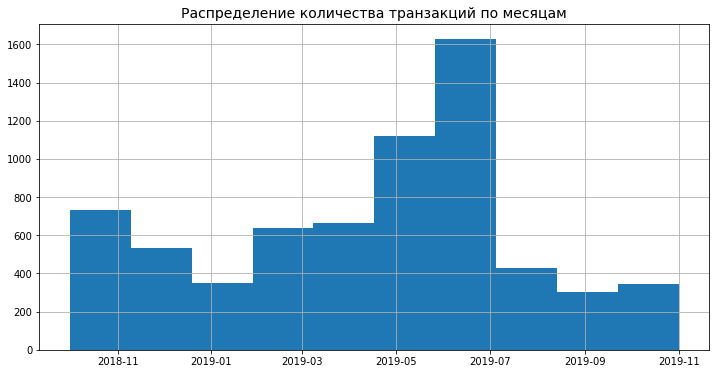

In [16]:
#Задаем размер графика
plt.figure(figsize=(12,6))

#Данные для графика
df['date'].hist()

#Выводим на экран название графика
plt.title('Распределение количества транзакций по месяцам', fontsize=14)
plt.show();

Судя по графику, можно сделать предположение о сезонности покупок. Так, с мая по июнь 2019 наблюдается высокое число транзакций, меньше всего транзакций было с конца августа по октябрь 2019, а также с конца декабря 2018 до первой декады февраля 2019.

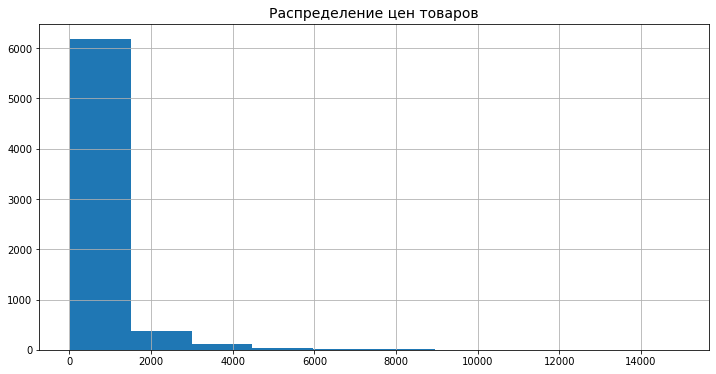

In [17]:
#Задаем размер графика
plt.figure(figsize=(12,6))

#Данные для графика
df['price'].hist()

#Выводим на экран название графика
plt.title('Распределение цен товаров', fontsize=14)
plt.show();

In [18]:
#Считаем перцентили
np.percentile(df['price'], [80, 95, 99])

array([ 599. , 1949. , 4225.4])

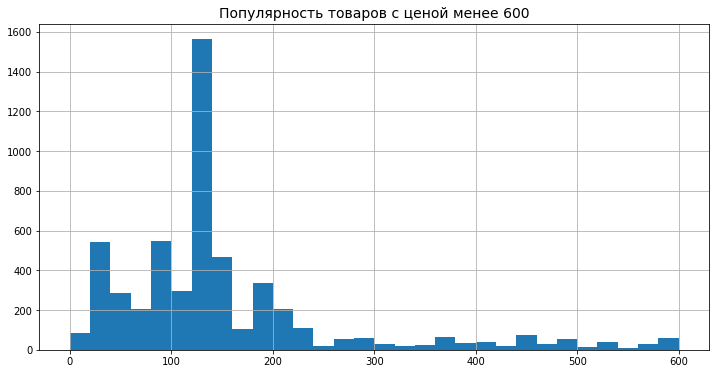

In [19]:
#Задаем размер графика
plt.figure(figsize=(12,6))

#Данные для графика
df['price'].hist(bins = 30, range = (0, 600))

#Выводим на экран название графика
plt.title('Популярность товаров с ценой менее 600', fontsize=14)
plt.show();

In [20]:
#Просмотрим распределение цен в нашей выборке
df[['price']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,6737.0,462.028499,871.296064,9.0,101.0,135.0,398.0,14917.0


Как мы видим, в нашем интернет-магазине за последние 13 месяцев часто выбирали товары (80%) с ценой меньше 600. Популярны недорогие товары с ценой от 100 до 200.

Минимальная цена товара  - 9, максимальная - 14 917. Половина наших товаров не дороже 135 и лишь 1% товаров в нашей выборке дороже 4 226.

In [21]:
#Добавим столбец с выручкой
df['revenue'] = df.price * df.quantity

In [22]:
#Просмотрим распределение выручки за каждый товар
df[['revenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,6737.0,720.094998,8352.100591,9.0,120.0,162.0,600.0,675000.0


In [23]:
df.head()

,date,customer_id,order_id,product,quantity,price,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0


In [24]:
#Сгруппируем данные по пользователю, заказу и дате
#df = df.groupby(['customer_id', 'order_id', 'date']).agg({'quantity':'sum', 'revenue':'sum'}).reset_index()

In [25]:
#Сгруппируем данные по пользователю
df.groupby(by = 'customer_id').agg({'quantity':'sum','order_id':'nunique','revenue':'sum'})\
    .reset_index()\
    .sort_values('revenue', ascending=False)\
    .head(10)

,customer_id,quantity,order_id,revenue
469,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1000,1,675000.0
1916,c971fb21-d54c-4134-938f-16b62ee86d3b,344,126,166988.0
287,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,900,1,114750.0
833,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,60,1,65220.0
742,4d93d3f6-8b24-403b-a74b-f5173e40d7db,409,35,60828.0
839,58a4c3cc-504f-43ea-a74a-bae19e665552,30,2,53232.0
1506,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,96,1,50770.0
199,146cd9bf-a95c-4afb-915b-5f6684b17444,334,1,49432.0
699,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,85,4,41900.0
1360,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,101,1,33680.0


In [26]:
#Сгруппируем данные по пользователю
df.groupby(by = 'customer_id').agg({'quantity':'sum','order_id':'nunique','revenue':'sum'})\
    .reset_index()\
    .sort_values('quantity', ascending=False)\
    .head(10)

,customer_id,quantity,order_id,revenue
469,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1000,1,675000.0
287,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,900,1,114750.0
1954,cd09ea73-d9ce-48c3-b4c5-018113735e80,600,1,17100.0
742,4d93d3f6-8b24-403b-a74b-f5173e40d7db,409,35,60828.0
1916,c971fb21-d54c-4134-938f-16b62ee86d3b,344,126,166988.0
199,146cd9bf-a95c-4afb-915b-5f6684b17444,334,1,49432.0
874,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,300,1,15300.0
2097,db77c238-3c80-4032-9e3c-c30a43f4a650,224,1,23660.0
1585,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,200,1,5800.0
1594,aa42dc38-780f-4b50-9a65-83b6fa64e766,170,1,8670.0


In [27]:
#Просмотрим выборочные данные
df.loc[df['customer_id'] == '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,revenue
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,675.0,675000.0


In [28]:
#Просмотрим выборочные данные
df.loc[df['customer_id'] == '146cd9bf-a95c-4afb-915b-5f6684b17444']

,date,customer_id,order_id,product,quantity,price,revenue
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0


In [29]:
#Просмотрим выборочные данные
df.loc[df['customer_id'] == '58a4c3cc-504f-43ea-a74a-bae19e665552']

,date,customer_id,order_id,product,quantity,price,revenue
1469,2019-01-10 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69766,простынь вафельная 200х180 см wellness rw180-01 100% хлопок,3,1949.0,5847.0
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,простынь вафельная 200х180 см wellness rw180-01 100% хлопок,27,1755.0,47385.0


In [30]:
#Просмотрим выборочные данные
df.loc[df['customer_id'] == 'cd09ea73-d9ce-48c3-b4c5-018113735e80']

,date,customer_id,order_id,product,quantity,price,revenue
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2850.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014",150,38.0,5700.0
266,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2850.0
267,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014",150,38.0,5700.0


Благодаря дополнительному столбцу с выручкой мы увидели, что наши пользователи отличаются между собой. Кто-то делает один заказ и не возвращается, кто-то совершает постоянные заказы. При этом присутствуют как пользователи, которые делают один большой заказ по числу товаров и не возвращается, так и постоянные покупатели, которые совершают регулярные небольшие заказы.

Также, замечены транзакции в разные дни по одному заказу. На данном этапе, можем предположить, что заказ был отгружен в разные дни.
Данные выглядят как неявные дубликаты, но также, пользователь мог повторно совершить точно такой же заказ.

Для возможности предположить другие ситуации, было бы очень полезно добавить доп информацию о действиях пользователя типа: "добавлен в корзину", "совершен заказ" и тому подобное. Пока, будем считать, что все транзакции - это отдельные и верные совершенные заказы.

Пока наших клиентов можно разделить на тех, кто совершал один или несколько заказов, на тех, кто совершал большие покупки и нет.
А также на тех, кто берет один товар и тех, кто совершает объемные покупки.

Посмотрим какие товары покупают наши клиенты.

In [31]:
#Просмотрим число уникальных значений
len(df['product'].unique())

2341

In [32]:
#Количество встречающихся значений
df['product'].value_counts().head(10)

рассада кабачка сорт зебра кассета 6 шт e6                              79
рассада кабачка сорт золотинка кассета 6 шт e6                          78
рассада кабачка сорт белогор кассета 6 шт e6                            77
пеларгония розебудная red pandora укорененный черенок                   76
рассада кабачка сорт горный, кассета по 6шт                             76
рассада кабачка сорт аэронавт, кассета по 6шт                           76
тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт    76
рассада огурца сорт каролина кассета 6 шт e6                            76
рассада огурец фараон ячейки по 6 шт е6                                 76
рассада патиссона сорт нло белый, кассета по 6шт                        75
Name: product, dtype: int64

Большой популярностью в нашем интернет-магазине пользуются "растения" - их заказывали чаще всего. Также, после просмотра заказов некоторых пользователей было видно наличие хозяйственных товаров и товаров для ремонта и дома.

In [33]:
#Группируем и сортируем по выручке
df.groupby('product')\
    .agg({'quantity': 'sum', 'price':set, 'revenue': 'sum'})\
    .reset_index()\
    .sort_values(by='revenue', ascending=False)\
    .head(10)

,product,quantity,price,revenue
112,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,{675.0},675000.0
1609,сумка-тележка 2-х колесная gimi argo красная,70,{1087.0},76090.0
1610,сумка-тележка 2-х колесная gimi argo синяя,61,"{1049.0, 1087.0}",65281.0
1188,простынь вафельная 200х180 см wellness rw180-01 100% хлопок,30,"{1755.0, 1949.0}",53232.0
1658,сумка-тележка хозяйственная rolser bab010 rojo joy-1800 красная,12,{4139.0},49668.0
185,вешалки мягкие для деликатных вещей 3 шт шоколад,335,"{164.0, 148.0}",49596.0
1891,тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,59,"{637.0, 574.0}",33992.0
1636,"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",6,"{5249.0, 6149.0}",33294.0
829,муляж яблоко 9 см красное,618,"{51.0, 59.0}",32702.0
290,гладильная доска ника гранд 122х42 см нг,18,{1799.0},32382.0


А вот наибольший доход принес нам товар из раздела хозяйственных товаров. За ним идут сумки-тележки одной марки, но разного цвета.

Далее, предлагаю посмотреть как часто совершают наши клиенты заказы и просмотреть средний чек на такого покупателя.

<a class="anchor" id="section_2_1"></a> 
### Количество заказов и средний чек на пользователя
<a class="anchor" href="#2">Вернуться к оглавлению</a>

In [34]:
#Добавим данные о дне, месяце, дне недели и год
df['date_day'] = df['date'].dt.date
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()

In [35]:
#Приведем столбец к нужному формату
df['date_day'] = pd.to_datetime(df['date_day'], format='%Y-%m-%d')

In [36]:
#Сгруппируем данные по дню и количеству уникальных пользователей
df.groupby('date_day').agg({'customer_id': 'nunique'}).sort_values(by = 'customer_id').describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,394.0,7.609137,3.586023,1.0,5.0,7.0,9.0,21.0


In [37]:
#Сгруппируем данные по дню и количеству уникальных заказов
df.groupby('date_day').agg({'order_id': 'nunique'}).sort_values(by = 'order_id').describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,394.0,8.027919,3.930922,1.0,5.0,8.0,10.0,21.0


In [38]:
#Сгруппируем данные по дню и количеству уникальных товаров
df.groupby('date_day').agg({'product': 'nunique'}).sort_values(by = 'product').describe().T

,count,mean,std,min,25%,50%,75%,max
product,394.0,14.192893,12.153528,1.0,6.0,11.0,18.0,96.0


У нас в среднем 7 уникальных пользователей в день, 8 заказов, в которых чаще всего добавлено 11 различных позиций товара.

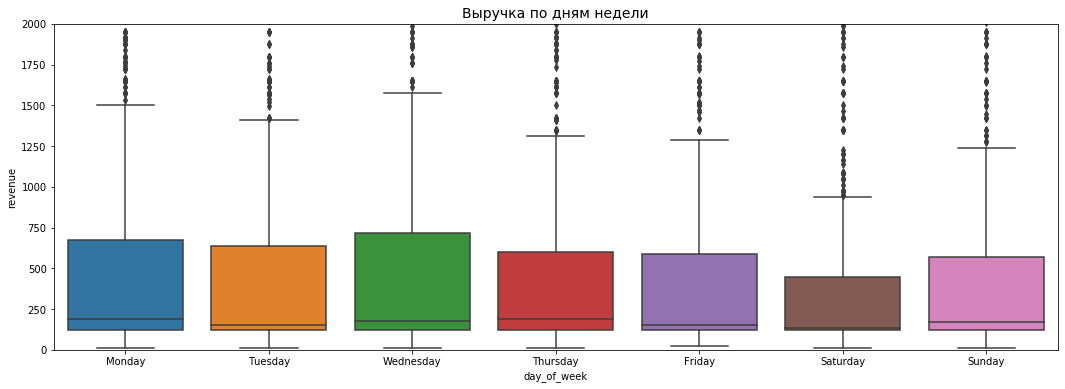

In [39]:
#Задаем размер графика
plt.figure(figsize=(18,6))

#Данные для графика
ax = sns.boxplot(x='day_of_week', y='revenue', data=df)

#Выводим на экран название графика
plt.title('Выручка по дням недели', fontsize=14)
ax.set_ylim(0, 2000)
plt.show();

Ежедневная выручка в разбивке по дням недели непревышает 750. При этом, в субботу и воскресенье - выручка ниже, чем в будние дни. Возможно, это связано с тем, что на выходных у наших клиентов мотивации сделать заказ меньше, чем в будние дни. Стоит обратить внимание на большое число "выбросов" в разные дни, в среду и четверг - их самое большее количество.

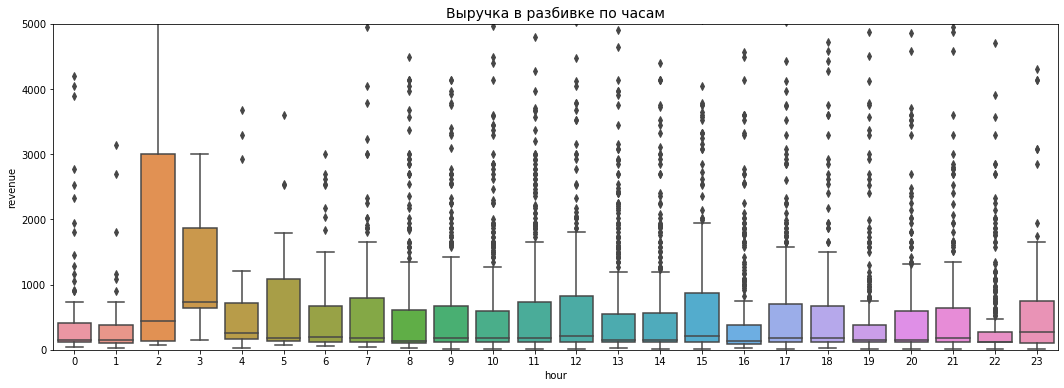

In [40]:
#Задаем размер графика
plt.figure(figsize=(18,6))

#Данные для графика
ax = sns.boxplot(x='hour', y='revenue', data=df)

#Выводим на экран название графика
plt.title('Выручка в разбивке по часам', fontsize=14)
ax.set_ylim(0, 5000)
plt.show();

In [41]:
#Просмотрим срез данных, сгруппированный по пользователям
df.query('hour > 1 and hour < 3')\
    .groupby(['customer_id','date_day'])\
    .agg(
    {'product':set,
     'order_id':'count', 
     'revenue':'sum'}
        )

,,product,order_id,revenue
customer_id,date_day,,,
0adba506-249c-40b5-839d-a59d7a275cd7,2019-10-14,{зверобой продырявленный оптимист d- 9 см},1,74.0
126dac4d-6486-49ed-a1be-9fd55a38a9de,2019-08-28,"{сумка-тележка хозяйственная andersen scala shopper, lini, синяя 112-108-90}",1,4574.0
15056e00-1aaf-483b-b429-4e9f41ee82b6,2019-04-24,{кружка luminarc дисней микки колорс 250 мл l2127-1},1,179.0
2eef43dd-ad75-4e55-a46d-edea403bcb6b,2019-08-16,{tepмокружка avex freeflow 700 мл сталь avex0776},1,2399.0
4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,2019-05-21,{мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок},1,74.0
51f04abe-a71a-4694-87b7-ad9ef4930e51,2019-05-25,{мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок},1,74.0
54437eae-ba9f-42fb-8b6f-68920ef12901,2018-12-24,{пуансеттия d-12 см белая},1,134.0
639c4989-b0ab-412a-b7ec-be394cb2d372,2018-11-05,{сумка-тележка хозяйственная rolser imx005 marengo logic dos+2 серая},1,6007.0
6e8c1c71-9e9c-49ed-96d4-513d6a587b43,2018-10-28,"{пеларгония розоцветная ред розебуд молодые растения, рассада пеларгония (герань) зональная блу айз mix смесь объем 0,5 л, бегония ампельная, диам. 12 см, хризантема корейская смесь окрасок объем 0,75 л}",4,613.0


Самые "пиковые часы", когда пользователи совершали заказы - 13 и 17. Также, были совершены заказы в 2 часа ночи, возможно, наши клиенты из других регионов. Было бы полезным собрать информацию о поле и геолокации пользователя(название города).

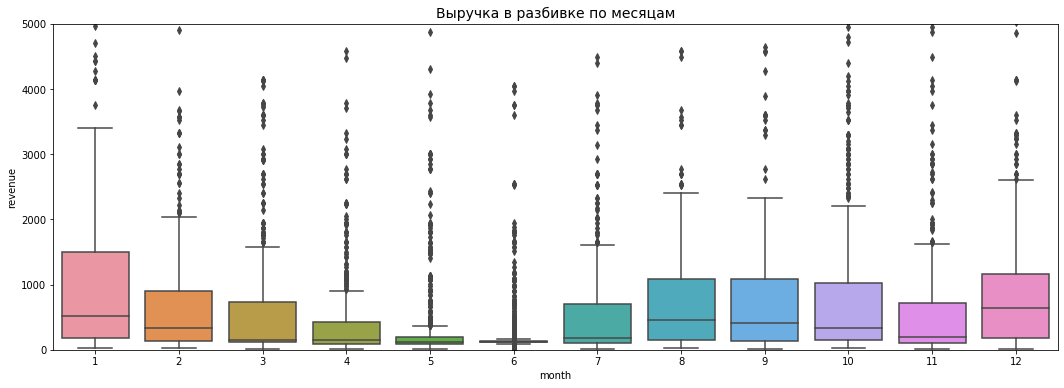

In [42]:
#Задаем размер графика
plt.figure(figsize=(18,6))

#Данные для графика
ax = sns.boxplot(x='month', y='revenue', data=df)

#Выводим на экран название графика
plt.title('Выручка в разбивке по месяцам', fontsize=14)
ax.set_ylim(0, 5000)
plt.show();

Январь - самый доходный месяц в нашей выборке, также стоит отметить - июнь, ноябрь и декабрь - в них присутствуют наибольшее количество "выбросов". "Стабильные месяцев" по получаемой выручке - с августа по октябрь.

In [43]:
#Считаем количество заказов и количество уникальных пользователей
order_per_user = df.groupby(['date_day']).agg({'customer_id': ['count','nunique']})

#Переименовываем столбцы полученной таблицы
order_per_user.columns = ['n_orders', 'n_users']

#Считаем среднее количество заказов на пользователя
order_per_user['order_per_user'] = order_per_user['n_orders'] / order_per_user['n_users']

In [44]:
#Выведем на экран таблицу
order_per_user.sort_values(by = 'order_per_user', ascending = False).head()

,n_orders,n_users,order_per_user
date_day,,,
2019-05-02,40,2,20.000000
2019-06-15,50,3,16.666667
2019-06-07,120,8,15.000000
2019-06-09,60,4,15.000000
2019-06-22,27,2,13.500000


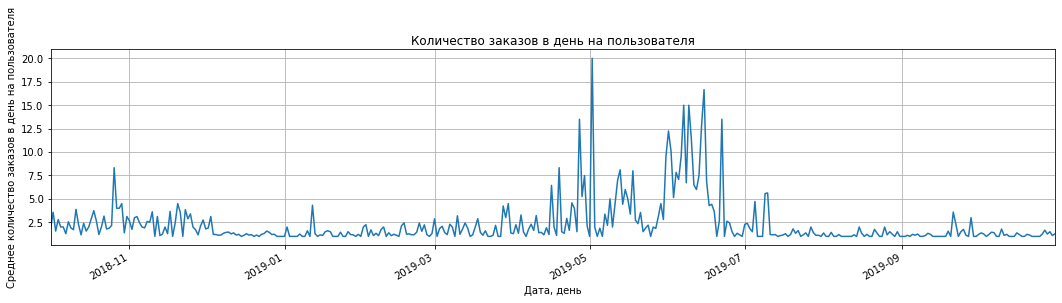

In [45]:
#Строим график по значениям "order_per_user" на каждый день
ax = order_per_user['order_per_user'].plot(grid=True, figsize=(18, 4), title = 'Количество заказов в день на пользователя')

#Подписываем оси
ax.set_ylabel('Среднее количество заказов в день на пользователя')
ax.set_xlabel('Дата, день');

In [46]:
# Определим первый месяц когда пользователь совершил действие
first_activity_month = df.groupby('customer_id').agg({'date_day':'min'}).reset_index()

In [47]:
# Меняем формат столбца date_day
first_activity_month['date_day'] = first_activity_month['date_day'].astype('datetime64[M]')

In [48]:
#Присвоим имена колонкам в полученной таблице
first_activity_month.columns = ['customer_id', 'first_activity_month']

In [49]:
#Переименуем полученную серию данных для последующего объединения
first_activity_month.name = 'first_activity_month'

In [50]:
#Добавляем данные о первом месяце посещения сервиса в общую таблицу
df = df.merge(first_activity_month, on='customer_id')

In [51]:
df['cohort_lifetime'] = (
    df['date_day'].astype('datetime64[M]') - 
    df['first_activity_month'].astype('datetime64[M]')
)

In [52]:
#В качестве делителя используем месяц
df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1,'M')

In [53]:
#Округляем до целых и приводим к формату "int"
df['cohort_lifetime'] = df['cohort_lifetime'].round().astype('int') 

In [54]:
#Группируем данные по когорте и считаем для каждой когорты количество активных пользователей на определенный месяц
cohorts = df.groupby(['first_activity_month','cohort_lifetime'])\
    .agg({'customer_id':'nunique'})\
    .reset_index() 

In [55]:
#Рассчитаем число пользователей в нулевом месяце
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','customer_id']]

In [56]:
#Переименовываем столбец для удобства "Число пользователей в когорте"
initial_users_count = initial_users_count.rename(columns={'customer_id':'cohort_users'})

In [57]:
#Добавляем в таблицу с когортами общую сумму пользователей этой когорты
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [58]:
#Разделим число активных пользователей на число пользователей когорты
cohorts['retention'] = cohorts['customer_id']/cohorts['cohort_users']

In [59]:
#Собираем сводную таблицу
retention_pivot = cohorts.pivot_table(
        index='first_activity_month',
        columns='cohort_lifetime',
        values='retention',
        aggfunc='sum')

#Добавляем среднее значение метрики когорт
retention_pivot.loc['mean'] = retention_pivot.mean()

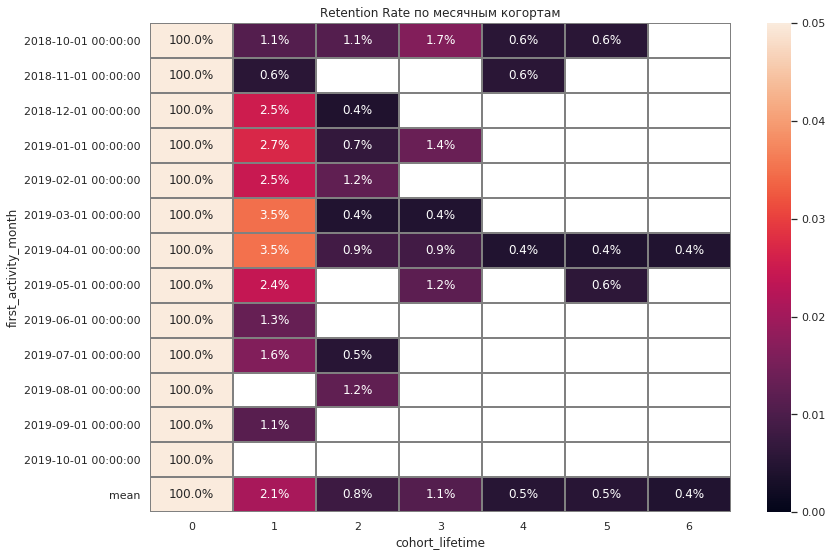

In [60]:
# Строим тепловую карту по сводной таблице
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.05);

Название нашего магазина иронично подходит под описание ситуации с возвращаемостью клиентов. 

После второго месяца жизни, почти никто из клиентов не возвращается. Самый высокий retention наблюдался у мартовской и апрельской когорт. Единицы пользователей из когорт января и апреля возвращаются к нам, что бы совершить заказ.

Пока пользователей все еще тут, нужно вводить меры по их удержанию. Например, предалагая повторные заказы, рассказывать о возможных полезных товарах для пользователя на основании сделанных покупок. Расширить каналы привлечения клиентов. 

In [61]:
#Найдем количество новых покупателей ежемесячно
cohort_sizes = df.groupby('first_activity_month').agg({'customer_id': 'nunique'}).reset_index()

In [62]:
#Переименуем колонку customer_id
cohort_sizes = cohort_sizes.rename(columns={'customer_id':'cohort_users'})

In [63]:
#Выведем на экран таблиц cohort_sizes
cohort_sizes

,first_activity_month,cohort_users
0,2018-10-01,181
1,2018-11-01,177
2,2018-12-01,237
3,2019-01-01,148
4,2019-02-01,243
5,2019-03-01,230
6,2019-04-01,228
7,2019-05-01,166
8,2019-06-01,152
9,2019-07-01,183


In [64]:
#Формируем когорты
cohorts = df.groupby(['first_activity_month', 'date_day']).agg({'order_id': 'nunique'}).reset_index()

In [65]:
#Соединяем две полученные таблицы
report = pd.merge(cohort_sizes, cohorts, on='first_activity_month')

In [66]:
#Определяем возраст когорты и приводим к нужному типу данных
report['age'] = (report['date_day'] - report['first_activity_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [67]:
#Выводим первые пять строк таблицы report
report.head()

,first_activity_month,cohort_users,date_day,order_id,age
0,2018-10-01,181,2018-10-01,11,0
1,2018-10-01,181,2018-10-02,15,0
2,2018-10-01,181,2018-10-03,8,0
3,2018-10-01,181,2018-10-04,11,0
4,2018-10-01,181,2018-10-05,7,0


In [68]:
#Считаем среднее количество покупок
report['avg_order'] = report['order_id'] / report['cohort_users']

In [69]:
#Формируем полученные данные в сводную таблицу
result = report.pivot_table(
        index='first_activity_month', 
        columns='age', 
        values='avg_order', 
        aggfunc='sum')

#Добавляем среднее значение метрики когорт
result.loc['mean'] = result.mean()

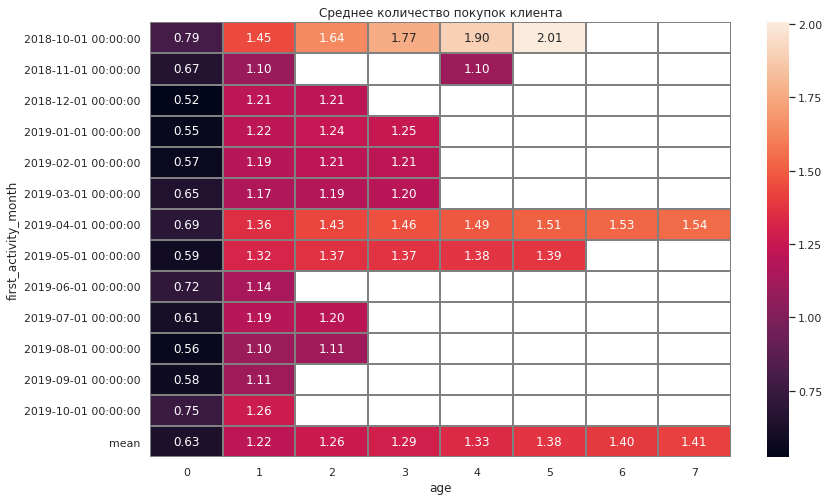

In [70]:
# Строим тепловую карту по сводной таблице
sns.set(style='white')
plt.figure(figsize=(13, 8))
plt.title('Среднее количество покупок клиента')
sns.heatmap(result.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Здесь выделяется майская когорта, которая в июне совершила большое количество заказов и в последующие месяцы изредка возвращалась и совершала заказы. В среднем, покупателей совершает 1-2 покупки.

In [71]:
#Просмотрим основную часть выборки по выручке
np.percentile(df.groupby('customer_id')['revenue'].sum(), [90,95,99])

array([ 3384. ,  5094. , 15108.5])

In [72]:
#Группируем полученные данные, суммируем выручку по каждому пользователю и считаем выручку на пользователя
orders_grouped_by_cohorts = df\
    .groupby(['first_activity_month','date_day'])\
    .agg({'revenue':'sum', 'customer_id':'nunique'})

orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['customer_id']

orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

In [73]:
#Формируем когорты
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['date_day'] - orders_grouped_by_cohorts['first_activity_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [74]:
#Строим сводную таблицу средних чеков наших когорт
lifetime_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean')

lifetime_pivot.loc['mean'] = lifetime_pivot.mean()

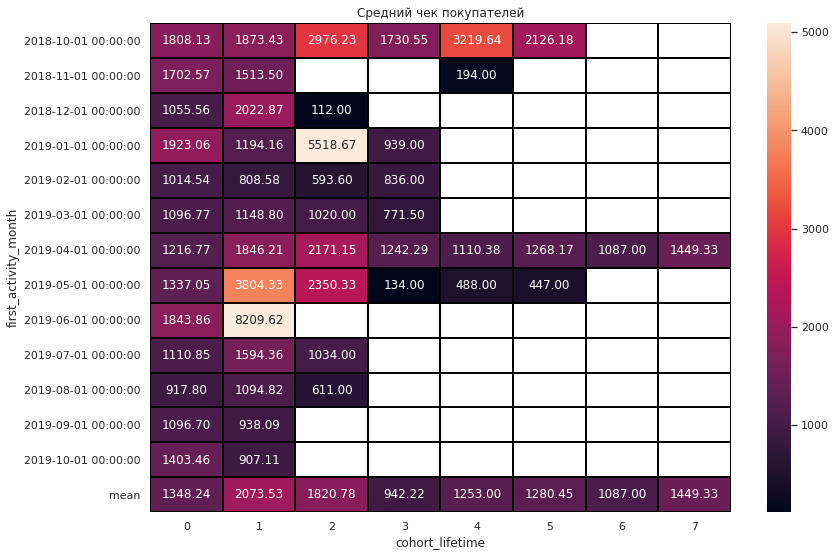

In [75]:
#Строим тепловую карту среднего чека
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(lifetime_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black', vmax=5094);

Мы видим, что средний чек на пользователя колеблется и изменяется из месяца в месяц. Наша майская когорта вернулась, совершила рекордное количество покупок для магазина и подняла показатель среднего чека вдвое, но в последующие месяцы неохотно совершала покупки.
Низкий средний чек показали когорты ноября и декабря. Декабрьская когорта вернулась в магазин в январе-феврале, совершила покупки и больше не возвращалась.

<a class="anchor" id="section_2_2"></a> 
### Когортный анализ и LTV
<a class="anchor" href="#2">Вернуться к оглавлению</a>

Просмотрев ситуацию с возвращаемостью клиентов и числом покупок - жизнь наших когорт крайне низкая. Предлагаю сгруппировать и посчитать средний LTV.

In [76]:
# Формируем данные по выручке
cohorts = df.groupby(['first_activity_month', 'date_day']).agg({'revenue': 'sum'}).reset_index()

In [77]:
# Объединяем две таблицы cohort_sizes и cohorts
report = pd.merge(cohort_sizes, cohorts, on='first_activity_month')

# Вычисляем средний ltv
report['lifetime'] = (report['date_day'] - report['first_activity_month']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
report['ltv'] = report['revenue'] / report['cohort_users']

result = report.pivot_table(
        index='first_activity_month', 
        columns='lifetime', 
        values='ltv', 
        aggfunc='mean')

#Добавляем среднее значение метрики когорт
result.loc['mean'] = result.mean()

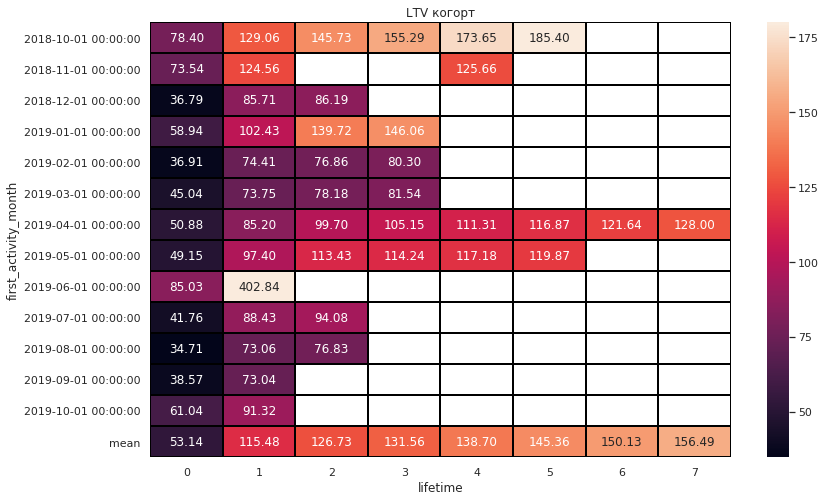

In [78]:
# Строим тепловую карту среднего ltv когорт
plt.figure(figsize=(13, 8))
plt.title('LTV когорт')
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black', vmax = 180);

LTV когорт почти не поднимается до 180, самый высокий равномерно нарастающий LTV показала январская когорта. Когорты апреля и мая показывают небольшой рост с каждым месяцем жизни.

В целом, проведя анализ числа покупок, среднего чек, Retention rate и LTV, можно сделать первые выводы о наших пользователях на основе когортного анализа:

Когорта **2018-10-01**: средний чек - 3219.64 на пятый месяц жизни, среднее количество покупок - 3.87, низкий retention, max ltv - 185.40 не вернулись. Обратить внимание - данная группа приносила стабильный доход, возможно остались лояльные клиенты из данной когорты, которые захотят вернуться.

Когорта **2018-11-01**: max средний чек - 1702.57 на первый месяц жизни, среднее количество покупок - 2.44, низкий retention, max ltv - 125.66 не вернулись

Когорта **2018-12-01**: max средний чек - 2022.87 на второй месяц жизни, среднее количество покупок - 1.46, низкий retention, max ltv - 86.19 не вернулись

Когорта **2019-01-01**: max средний чек - 5518.67 на третий месяц жизни, среднее количество покупок - 1.54, низкий retention, max ltv - 146.06 не вернулись. Высокий показатель среднего чека мог быть обусловлен праздниками в марте, возможно, сезонные клиенты.

Когорта **2019-02-01**: max средний чек - 1012.54 на первый месяц жизни, среднее количество покупок - 1.68, низкий retention, max ltv - 80.30 не вернулись

Когорта **2019-03-01**: max средний чек - 1148.80 на второй месяц жизни, среднее количество покупок - 2.33, низкий retention, max ltv - 81.54 не вернулись. Возможно, сезонные клиенты.

Когорта **2019-04-01**: max средний чек - 2171.15 на третий месяц жизни, среднее количество покупок - 3.44, низкий retention, max ltv - 128. Обратить внимание - возможно, в данной группе остались лояльные клиенты, которые могут вернуться. Возможно, сезонные клиенты.

Когорта **2019-05-01**: max средний чек - 3804.33 на второй месяц жизни, среднее количество покупок - 11.34, низкий retention, max ltv - 119.87 Обратить внимание - возможно, в данной группе остались лояльные клиенты, которые могут вернуться. Возможно, сезонные клиенты.

Когорта **2019-06-01**: max средний чек -8209.62 на второй месяц жизни , среднее количество покупок - 2.14, низкий retention, max ltv - 402.84 не вернулись

Когорта **2019-07-01**: max средний чек - 1594.36 на второй месяц жизни, среднее количество покупок - 2.14, низкий retention, max ltv - 94.08 не вернулись

Когорта **2019-08-01**: max средний чек - 1094.82 на второй месяц жизни, среднее количество покупок - 1.31, низкий retention, max ltv - 76.83 не вернулись.

Когорта **2019-09-01**: max средний чек - 1096.70 в первый месяц жизни, среднее количество покупок - 1.41, низкий retention, max ltv - 73.04 Обратить внимание - возможно, в данной группе остались лояльные клиенты, которые могут вернуться.

Когорта **2019-10-01**: max средний чек - 1403.46 в первый месяц жизни, среднее количество покупок - 1.44, низкий retention, max ltv - 91.32

<a class="anchor" id="chapter3"></a> 
## Сегментация пользователей
<a class="anchor" href="#2">Вернуться к оглавлению</a>

На основании предварительного анализа, есть предложение сегментировать пользователей с помощью **RFM-score**.

*Recency* — давность (как давно наши клиенты что-то покупали)

*Frequency* — частота (как часто они у нас покупают)

*Monetary* — деньги (общая сумма покупок)

С помощью этого анализа, мы сможем выделить клиентов, что бы определить как работать с каждой группой клиентов.

In [79]:
#Выведем на экран первые пять строк таблицы
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,date_day,month,year,hour,day_of_week,first_activity_month,cohort_lifetime
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018-10-01,10,2018,0,Monday,2018-10-01,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,194.0,2018-10-01,10,2018,0,Monday,2018-10-01,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,10,2018,0,Monday,2018-10-01,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018-10-01,10,2018,0,Monday,2018-10-01,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,10,2018,0,Monday,2018-10-01,0


In [80]:
#Сгруппируем данные по пользователю, дате и заказу
rfm = df.groupby(['customer_id', 'order_id'])\
        .agg(
                {'first_activity_month':'min', 
                 'date':'last', 
                 'revenue':'sum'}
            )\
        .reset_index()\
        .rename(
            {'revenue':'monetary', 
             'date':'last_transaction',
             'order_id':'frequency'}, 
        axis=1)

In [81]:
#Выведем первые пять строк таблицы
rfm.head()

,customer_id,frequency,first_activity_month,last_transaction,monetary
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,2019-10-01,2019-10-16 08:00:00,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,70290,2019-02-01,2019-02-16 11:00:00,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,2019-10-01,2019-10-14 23:00:00,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,2019-01-01,2019-01-27 17:00:00,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,2019-09-01,2019-09-29 17:00:00,2324.0


In [82]:
#Сгруппируем данные по пользователю
rfm = rfm.groupby('customer_id')\
            .agg(
                {'frequency':'nunique', 
                 'monetary':'sum', 
                 'last_transaction':'last'})\
            .reset_index()

In [83]:
#Выведем первые пять строк таблицы
rfm.head()

,customer_id,frequency,monetary,last_transaction
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,2019-10-16 08:00:00
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,2019-02-16 11:00:00
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,2019-10-14 23:00:00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,2019-01-27 17:00:00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2019-09-29 17:00:00


In [84]:
#Сохраним в столбце максимальную дату датасета
rfm['end_date'] = df['date'].max()

In [85]:
#Найдем разницу между максимальной датой и последней транзакцией пользователя
rfm['recency'] = (rfm.end_date - rfm.last_transaction) / np.timedelta64(1, 'D')

In [86]:
#Выведем первые пять строк таблицы
rfm.head()

,customer_id,frequency,monetary,last_transaction,end_date,recency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,2019-10-16 08:00:00,2019-10-31 16:00:00,15.333333
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,2019-02-16 11:00:00,2019-10-31 16:00:00,257.208333
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,2019-10-14 23:00:00,2019-10-31 16:00:00,16.708333
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,2019-01-27 17:00:00,2019-10-31 16:00:00,276.958333
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2019-09-29 17:00:00,2019-10-31 16:00:00,31.958333


In [87]:
#С помощью qcut разделим пользователей на 4 сегмента (обратная связь)
rfm['r'] = 5 - (pd.qcut(rfm['recency'],4,labels=False) + 1)

In [88]:
#Сгруппируем данные по столбцу r
rfm.groupby('r')['recency'].agg(['mean','count'])

,mean,count
r,,
1,344.697526,613
2,250.864856,612
3,163.812058,613
4,54.186582,613


In [89]:
#С помощью qcut разделим пользователей на 4 сегмента
rfm['f'] = pd.qcut(rfm['frequency'],4,labels=False,duplicates='drop')+1

In [90]:
#Сгруппируем данные по столбцу f
rfm.groupby('f')['frequency'].agg(['mean','count'])

,mean,count
f,,
1,1.149327,2451


In [91]:
#Сгруппируем данные по столбцу и выведем на экран значения в сегменте
rfm.groupby('f')['frequency'].agg(set)

f
1    {1, 2, 3, 4, 5, 35, 7, 17, 126}
Name: frequency, dtype: object

In [92]:
#Выведем на экран количество возможных значений
rfm['frequency'].value_counts()

1      2291
2       132
3        20
4         3
35        1
17        1
7         1
5         1
126       1
Name: frequency, dtype: int64

Нам не удалось разделить пользователей с помощью функции `qcut`, потому как, как мы видели ранее, наши пользователи редко совершают более одного заказа. Тем не менее, присутствут пользователи, которые совершают регулярно заказы, хоть и не так часто. Поэтому, напишем функцию, которые распределит очки в зависимости от заданной нами шкалы:

1 балл - если число покупок 1,

2 балла - если число покупок 2,

3 балла - если число покупок от 3 до 5,

4 балла - свыше 6 покупок.

In [93]:
#Функция проверяет количество покупок по столбцу и присваивает балл
def get_score(value):
    if value in [1]:
        return 1
    if value in [2,3,4,5]:
        return 2
    if value in [17, 35]:
        return 3
    return 4 

In [94]:
#Применяем функцию и сохраняем значения в столбец
rfm['f'] = rfm['frequency'].apply(get_score)

In [95]:
#Сгруппируем данные по столбцу f
rfm.groupby('f')['frequency'].agg(['mean','count'])

,mean,count
f,,
1,1.000000,2291
2,2.185897,156
3,26.000000,2
4,66.500000,2


In [96]:
#С помощью qcut разделим пользователей на 4 сегмента
rfm['m'] = pd.qcut(rfm['monetary'],4,labels=False) + 1

In [97]:
#Сгруппируем данные по столбцу m
rfm.groupby('m')['monetary'].agg(['mean','count'])

,mean,count
m,,
1,163.962480,613
2,532.158238,613
3,1142.805112,626
4,6192.257095,599


Мы распределили нашим пользователям баллы в зависимости от их активности, частоте покупок, суммам заказа. Теперь можем приступить к их сегментации.
Разделим наших клиентов на несколько сегментов:

In [98]:
#Считаем количество набранных баллов
rfm['rfm_score'] = (rfm['r'] + rfm['f'] + rfm['m'])

In [99]:
#Функция присваивает название сегмента в зависимости от числа баллов
def rfm_level(df):
    if df['rfm_score'] >= 10:
        return 'Loyal'
    elif ((df['rfm_score'] >= 7) and (df['rfm_score'] < 10)):
        return 'Potential'
    elif ((df['rfm_score'] >= 6) and (df['rfm_score'] < 7)):
        return 'Promising'
    else:
        return 'Needs Attention'

In [100]:
#Присваиваем сегмент пользователю с помощью функции
rfm['segment'] = rfm.apply(rfm_level,axis=1)

In [101]:
#Выводим ТОП-10 клиентов
rfm.sort_values('rfm_score',ascending=False).head(10)

,customer_id,frequency,monetary,last_transaction,end_date,recency,r,f,m,rfm_score,segment
1101,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21713.0,2019-10-31 14:00:00,2019-10-31 16:00:00,0.083333,4,3,4,11,Loyal
1748,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779.0,2019-04-23 17:00:00,2019-10-31 16:00:00,190.958333,3,4,4,11,Loyal
1168,7b0b570c-16c7-4aed-b302-13fe1830d1e9,2,3223.0,2019-10-06 12:00:00,2019-10-31 16:00:00,25.166667,4,2,4,10,Loyal
1916,c971fb21-d54c-4134-938f-16b62ee86d3b,126,166988.0,2019-03-06 12:00:00,2019-10-31 16:00:00,239.166667,2,4,4,10,Loyal
181,126dac4d-6486-49ed-a1be-9fd55a38a9de,2,9148.0,2019-08-28 02:00:00,2019-10-31 16:00:00,64.583333,4,2,4,10,Loyal
555,399da134-5db6-4861-89fc-6595e7583e98,2,2736.0,2019-08-28 12:00:00,2019-10-31 16:00:00,64.166667,4,2,4,10,Loyal
2209,e8204583-4d55-4724-ad3f-049c7db43bdd,3,3102.0,2019-09-06 15:00:00,2019-10-31 16:00:00,55.041667,4,2,4,10,Loyal
2402,facadcf2-2c13-4d8f-baa3-567821546534,2,7049.0,2019-07-19 08:00:00,2019-10-31 16:00:00,104.333333,4,2,4,10,Loyal
812,55f5aaea-0a3f-46c0-8677-e0d5be2d19ee,2,1858.0,2019-10-30 10:00:00,2019-10-31 16:00:00,1.250000,4,2,4,10,Loyal
1521,a16e499f-f295-4b6c-b846-aeed6477eb70,2,2961.0,2019-10-02 09:00:00,2019-10-31 16:00:00,29.291667,4,2,4,10,Loyal


In [102]:
#Выведем на экран название сегментов и их показатели
segments = rfm.groupby('segment')\
    .agg(
    {'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}
        )
segments

recency frequency      monetary      
                       mean      mean          mean count
segment                                                  
Loyal             70.357143  9.000000  12639.000000    21
Needs Attention  280.854143  1.017877    467.712849   895
Potential        128.243961  1.184270   3527.094382   890
Promising        203.849548  1.027907   1594.021705   645

Как мы видим, у нас очень мало полезных клиентов для компании. Почти вся аудитория интернет-магазина делает разовые заказы и не возвращается в магазин.

**Потенциальные клиенты** - возвращаются к нам, совершают заказ на значимое количество и сумму покупки. Такому сегменту можно предложить акции на те товары, которые они уже покупали. Акцию желательно ограничить по времени, что бы мотивировать клиента совершить заказ на ранее понравившийся товар.

**Возможные клиенты** - совершают заказ, почти не возвращаются. Что бы перейти в сегмент выше, данным клиентам можно предложить значимые для них бонусы и подарки, рассказывать о возможностях и предложениях нашего магазина.

**Требуют внимания** - совершают первую покупку и пропадают. К таким клиентом можно предложить пройти опрос, например, за бонусы или подарки. В опросе уточнить, что им понравилось/не понравилось в нашем интернет-магазине, возможно, на каких-то этапах у них возникли трудности с совершением заказа, предпочитаемый способ оплаты, впечатления от службы доставки. По таким клиентам жедательно провести доп анализ с разбором воронки, что бы понять, как часто они вообще заходили к нам на страницу и на каком шаге отваливались.

<a class="anchor" id="chapter4"></a> 
## Проверка гипотез
<a class="anchor" href="#2">Вернуться к оглавлению</a>

Выше, при проведении анализа, мы увидели, что, пользователи совершают заказы в разное время суток и дни. Давайте проверим гипотезы:

- Н0: Выручка в интернет-магазине не зависит от времени суток (Альтернативная гипотеза: Выручка в интернет-магазине различается по времени суток)

- Н0: Выручка в выходные дни такая же как и в будние (Альтернативная гипотеза: Выручка различается в выходные дни отличается от выручки в будние дни)

In [103]:
#Выводим на экран случайную строку и данных
df.sample()

,date,customer_id,order_id,product,quantity,price,revenue,date_day,month,year,hour,day_of_week,first_activity_month,cohort_lifetime
6571,2019-10-08 20:00:00,d54fa8d9-144b-4c92-a916-81af6bbdebe7,72899,тарелка десертная хелло китти свит пинк 20 см h5479 luminarc,1,187.0,187.0,2019-10-08,10,2019,20,Tuesday,2019-10-01,0


In [104]:
#Просматриваем уникальные значения столбца с часами
df['hour'].unique()

array([ 0,  8,  9, 10,  7, 13, 15, 17, 14, 11, 16, 12, 18, 21, 19, 20,  4,
        3,  6,  5, 22, 23,  1,  2])

In [105]:
#Сохраняем срезы данных
df_am = df.query('0<=hour<=12')
df_pm = df.query('12<hour<24')

In [106]:
#Проводим проверку гипотез
alpha = 0.05

In [107]:
display('{0:.3f}'.format(st.mannwhitneyu(df_am['revenue'], df_pm['revenue'])[1]))

'0.001'

p-value меньше 0.05, различия между дневной и ночной выручкой статистически значима.

In [108]:
#Выделяем номер дня недели в отдельный столбец
df['weekday'] = df['date'].dt.weekday

In [109]:
#Сохраняем срезы данных
weekday = df.query('weekday<=5')
holiday = df.query('6<=weekday')

In [110]:
#Проводим проверку гипотез
alpha = 0.05

In [111]:
display('{0:.3f}'.format(st.mannwhitneyu(weekday['revenue'], holiday['revenue'])[1]))

'0.244'

p-value больше 0.05, отсутствуют различия между выручкой между выходными и будними днями.

Итак, у нас получилось, что выручка интернет-магазина зависит от времени суток и не зависит от буднего или выходного дня. Хочется отметить, что проверка гипотезы по дням недели показала `p-value` очень близким к `alpha`.

<a class="anchor" id="chapter5"></a> 
## Выводы и рекомендации
<a class="anchor" href="#2">Вернуться к оглавлению</a>

В ходе исследования данных, мы разделили наших пользователей на 4 сегмента:

In [112]:
segments

recency frequency      monetary      
                       mean      mean          mean count
segment                                                  
Loyal             70.357143  9.000000  12639.000000    21
Needs Attention  280.854143  1.017877    467.712849   895
Potential        128.243961  1.184270   3527.094382   890
Promising        203.849548  1.027907   1594.021705   645

**Лояльные** - регулярно совершают заказы, возвращаются к нам за повторными покупками. Их очень мало от общей выборки.

**Потенциальные клиенты** - возвращаются к нам, совершают заказ на значимое количество и сумму покупки. Такому сегменту можно предложить акции на те товары, которые они уже покупали. Акцию желательно ограничить по времени, что бы мотивировать клиента совершить заказ на ранее понравившийся товар.

**Возможные клиенты** - совершают заказ, почти не возвращаются. Что бы перейти в сегмент выше, данным клиентам можно предложить значимые для них бонусы и подарки, рассказывать о возможностях и предложениях нашего магазина.

**Требуют внимания** - совершают первую покупку и пропадают. К таким клиентом можно предложить пройти опрос, например, за бонусы или подарки. В опросе уточнить, что им понравилось/не понравилось в нашем интернет-магазине, возможно, на каких-то этапах у них возникли трудности с совершением заказа, предпочитаемый способ оплаты, впечатления от службы доставки. По таким клиентам желательно провести доп анализ с разбором воронки, что бы понять, как часто они вообще заходили к нам на страницу и на каком шаге отваливались.

Средний чек на пользователя колеблется и изменяется из месяца в месяц. В среднем, покупатели совершают 1-2 покупки.

Надо повышать retenion rate! Например, для возврата клиентов из сегментов "Возможных клиентов" и "Требующих внимание" на площадку можно организовать разовую акцию с большими скидками в определенный день.

Возможно, не все пользователи доходят от стадии перехода на сайт до успешного совершения покупки. Доп. данные со статусами и переходами пользователя по сайту помогли бы определить проблемы и трудности, с которыми, возможно, столкнулся клиент и не совершил покупку.

Возможно, страдает служба логистики и невовремя доставляет заказ, из-за чего клиенты не возвращается к нам из-за недружелюбного сервиса.

Возможно, клиенту неудобен способ оплаты. В приведенных данных нет информации как оплачивает товар клиент - переводом, наличными, картой.

Нашему интернет-магазину важно иметь лояльных клиентов, так как для компании существенно снижаются затраты на его привлечение и удержание, он менее чувствителен к цене, а значит можно предложить большее число товаров. Также, лояльный клиент может порекомендовать нас своим друзьям и знакомым, тем самым мы получим альтернативный низкозатратный канал.

Также, для более целевых предложений, могли бы быть полезными дополнительные данные, такие как: возраст, геолокация, пол, тип девайса/ОС. Это позволило бы предоставить более значимые для клиента акции, предложения и скидки.

Также, следует делать сегментацию и анализ состояния клиентов с периодичностью, например, полгода-год. Иначе, можно обнаружить, что сегменты, дающие в прошлом устойчивый доход, вдруг уменьшились.

<a class="anchor" id="chapter6"></a> 
## Дополнительные материалы
<a class="anchor" href="#2">Вернуться к оглавлению</a>

Ссылка на дашборд: <https://public.tableau.com/app/profile/dinara5158/viz/Dash_16223956879860/Dashboard1>
1. Постройте **диаграмму количества покупок** по дням.
2. Добавьте индикатор количества покупателей.
3. Добавьте фильтр дашборда по дате совершения покупки.

Презентация: <https://drive.google.com/file/d/1KDJ52Pq-1CRnkKy96mxOt6NCY79oAnKw/view?usp=sharing>